In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pickle

%matplotlib inline

## Data Acquisition

In [2]:
# !wget https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/dataset_sms_spam_v1.csv -O dataset_sms_spam.csv

--2023-10-16 06:03:44--  https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/dataset_sms_spam_v1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128896 (126K) [text/plain]
Saving to: ‘dataset_sms_spam.csv’

dataset_sms_spam.cs 100%[===================>] 125.88K  --.-KB/s    in 0.003s  

2023-10-16 06:03:44 (36.8 MB/s) - ‘dataset_sms_spam.csv’ saved [128896/128896]



In [9]:
# !wget https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/key_norm.csv -O key_norm.csv

--2023-10-16 06:10:20--  https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/key_norm.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80969 (79K) [text/plain]
Saving to: ‘key_norm.csv’

key_norm.csv        100%[===================>]  79.07K  --.-KB/s    in 0.002s  

2023-10-16 06:10:20 (33.8 MB/s) - ‘key_norm.csv’ saved [80969/80969]



In [3]:
data = pd.read_csv('data/dataset_sms_spam.csv')
data.head()

,teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   teks    1143 non-null   object
 1   label   1143 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 18.0+ KB


In [5]:
print('Total Jumlah SMS:', data.shape[0], 'SMS\n')
print('Total Jumlah SMS Normal\t:', data[data['label'] == 0].shape[0], 'SMS\n')
print('Total Jumlah SMS Penipuan\t:', data[data['label'] == 1].shape[0], 'SMS\n')
print('Total Jumlah SMS Promo\t:', data[data['label'] == 2].shape[0], 'SMS\n')

Total Jumlah SMS: 1143 SMS

Total Jumlah SMS Normal	: 569 SMS

Total Jumlah SMS Penipuan	: 335 SMS

Total Jumlah SMS Promo	: 239 SMS



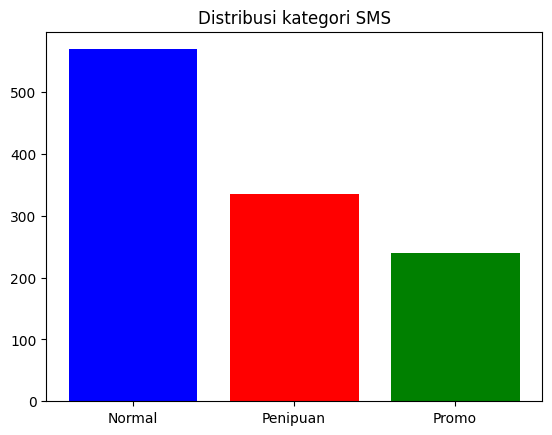

In [7]:
height = [data[data['label'] == 0].shape[0], data[data['label'] == 1].shape[0], data[data['label'] == 2].shape[0]]
bars = ('Normal', 'Penipuan', 'Promo')
y_pos = np.arange(len(bars))

plt.bar(y_pos, height, color=['blue', 'red', 'green'])
plt.xticks(y_pos, bars)
plt.title('Distribusi kategori SMS')

plt.show()

## Text Processing

### Case Folding

In [8]:
import re

def casefolding(text):
    text = text.lower() # Lowercase
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # Remove URL
    text = re.sub(r'\@\w+|\#', '', text) # Remove @ and #
    text = re.sub(r'[^a-z\s]', '', text) # Remove non-alphabet
    text = text.strip() # Remove whitespace leading & trailing
    return text

### Slang Word Normalization

In [10]:
key_norm = pd.read_csv('data/key_norm.csv')
print(key_norm.head())

key_norm.shape

   _id      singkat       hasil
0    1         abis       habis
1    2       accent     tekanan
2    3       accept      terima
3    4     accident  kecelakaan
4    5  achievement    prestasi


(3720, 3)

In [11]:
def text_normalize(text):
    text = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0] if (key_norm['singkat'] == word).any() else word for word in text.split()])
    text = str.lower(text)
    return text

### Filtering (Stopword Removal)

In [12]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

stopwords_ind = stopwords.words('indonesian')
len(stopwords_ind)

758

In [14]:
print(stopwords_ind[:20])

['ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 'akan', 'akankah', 'akhir', 'akhiri', 'akhirnya', 'aku', 'akulah', 'amat', 'amatlah', 'anda', 'andalah', 'antar', 'antara']


In [15]:
more_stopwords = ['tsel', 'gb', 'rb']

stopwords_ind += more_stopwords

def removing_stop_words(text):
    clean_words = []
    text = text.split()
    for word in text:
        if word not in stopwords_ind:
            clean_words.append(word)
    
    return ' '.join(clean_words)

### Stemming

In [16]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming(text):
    text = stemmer.stem(text)
    return text

In [17]:
def text_processing(text):
    text = casefolding(text)
    text = text_normalize(text)
    text = removing_stop_words(text)
    text = stemming(text)
    return text

In [18]:
%time
data['clean_teks'] = data['teks'].apply(text_processing)

CPU times: user 0 ns, sys: 4 µs, total: 4 µs
Wall time: 8.11 µs


In [19]:
data

,teks,label,clean_teks
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2,promo beli paket flash my telkomsel app extra ...
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2,rupiah ribu spesial pilih aktif promo sd novem...
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2,pulang hormat sisa kuota flash kb download myt...
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2,pulang hormat sisa kuota flash kb download myt...
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2,rupiah ribu spesial pilih aktif buru skb
...,...,...,...
1138,"Yooo sama2, oke nanti aku umumin di grup kelas",0,yooo oke umumin grup kelas
1139,😁 sebelumnya ga ad nulis kerudung. Kirain warn...,0,nulis kerudung kirain warna jins
1140,Mba mau kirim 300 ya,0,mbak kirim ya
1141,nama1 beaok bwrangkat pagi...mau cas atay tra...,0,nama beaok bwrangkat pagimau cas atay tranfer


In [20]:
data.to_csv('data/data_clean.csv', index=False)

## Feature Engineering

In [21]:
X = data['clean_teks']
y = data['label']

### Feature Extraction (Bag of Words & N-Gram)

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

# Bow - Unigram
bow = CountVectorizer(ngram_range=(1,1))
bow.fit(X)

CountVectorizer()

In [23]:
len(bow.get_feature_names_out())

3255

In [24]:
print(bow.get_feature_names_out()[:10])

['aa' 'aamiiiin' 'aamiin' 'ab' 'abadi' 'abai' 'abbee' 'abdul' 'acara'
 'acaratks']


In [26]:
X_bow = bow.transform(X).toarray()
print(X_bow.shape)
X_bow

(1143, 3255)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [29]:
data_bow = pd.DataFrame(X_bow, columns=bow.get_feature_names_out())

data_bow

,aa,aamiiiin,aamiin,ab,abadi,abai,abbee,abdul,acara,acaratks,...,yudisium,yuk,yuks,yuni,yunit,zalora,zarkasi,zjt,zona,ztkm
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1139,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1140,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1141,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
with open('model/bow.pkl', 'wb') as file:
    pickle.dump(bow, file)

### Feature Extraction (TF-IDF & N-Gram)

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(ngram_range=(1,1))
tf_idf.fit(X)

TfidfVectorizer()

In [34]:
X_tf_idf = tf_idf.transform(X).toarray()
print(X_tf_idf.shape)
X_tf_idf

(1143, 3255)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [35]:
data_tf_idf = pd.DataFrame(X_tf_idf, columns=tf_idf.get_feature_names_out())
data_tf_idf

,aa,aamiiiin,aamiin,ab,abadi,abai,abbee,abdul,acara,acaratks,...,yudisium,yuk,yuks,yuni,yunit,zalora,zarkasi,zjt,zona,ztkm
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
with open('model/tf_idf.pkl', 'wb') as file:
    pickle.dump(tf_idf, file)

### Feature Selection

In [37]:
X = np.array(data_tf_idf)
y = np.array(y)

In [38]:
from sklearn.feature_selection import SelectKBest, chi2

chi2_features = SelectKBest(chi2, k=1000)
X_kbest_features = chi2_features.fit_transform(X, y)

print(f"Original feature number: {X.shape[1]}")
print(f"Reduced feature number: {X_kbest_features.shape[1]}")

Original feature number: 3255
Reduced feature number: 1000


In [39]:
data_chi2 = pd.DataFrame(chi2_features.scores_, columns=['nilai'])
data_chi2

,nilai
0,0.835686
1,0.419591
2,1.558607
3,0.716125
4,0.800213
...,...
3250,1.180239
3251,0.503162
3252,0.716125
3253,2.917381


In [40]:
# chi2_features.scores_ adalah nilai chi-square, semakin tinggi nilainya maka semakin baik fiturnya

feature = tf_idf.get_feature_names_out()
data_chi2['fitur'] = feature
data_chi2

,nilai,fitur
0,0.835686,aa
1,0.419591,aamiiiin
2,1.558607,aamiin
3,0.716125,ab
4,0.800213,abadi
...,...,...
3250,1.180239,zalora
3251,0.503162,zarkasi
3252,0.716125,zjt
3253,2.917381,zona


In [42]:
data_chi2.sort_values(by='nilai', ascending=False)

,nilai,fitur
2088,49.086259,paket
1033,46.332827,hadiah
1550,45.590080,kuota
2179,36.616720,pin
1487,34.468204,klik
...,...,...
306,0.044468,bca
608,0.036878,daftar
1695,0.031548,maksimal
530,0.013734,cepat


In [43]:
# Menampilkan mask pada feature yang diseleksi
# False berarti fitur tidak terpilih dan True berarti fitur terpilih


mask = chi2_features.get_support()
mask

array([False, False,  True, ..., False,  True, False])

In [45]:
# Menampilkan fitur-fitur terpilih berdasarkan mask atau nilai tertinggi yang sudah dikalkulasi pada Chi-Square
new_feature = []
for bool, f in zip(mask, feature):
    if bool:
        new_feature.append(f)
        selected_feature = new_feature

print(selected_feature)

['aamiin', 'agam', 'agen', 'ags', 'agst', 'agsts', 'agt', 'agtskinfodlj', 'agun', 'agustuskunjungi', 'ajak', 'akses', 'aktif', 'aktivasi', 'alam', 'alamsyah', 'aliando', 'all', 'aman', 'amanda', 'an', 'andabch', 'andajf', 'andika', 'andromax', 'angga', 'angpaopoinsenyum', 'angsur', 'anrasto', 'ap', 'apa', 'aplikasi', 'app', 'appleplay', 'apps', 'appsinapps', 'argo', 'armada', 'artha', 'artisartis', 'arya', 'as', 'asa', 'asli', 'ass', 'assalamualaikum', 'at', 'atas', 'ato', 'aug', 'augsept', 'avanza', 'axiata', 'axis', 'axisnet', 'ayah', 'ayam', 'ayo', 'bagi', 'baik', 'bakmi', 'balas', 'ball', 'bandung', 'bandungmulai', 'bang', 'banget', 'bank', 'banting', 'banyak', 'bapa', 'bareng', 'barokahmp', 'baru', 'baruqskrng', 'baskin', 'batas', 'batin', 'bawa', 'bayar', 'bb', 'bbm', 'bch', 'bebek', 'beda', 'belanja', 'beli', 'beliau', 'belikan', 'bentar', 'berangkat', 'beres', 'berkat', 'berlakupromo', 'berrybenka', 'besok', 'bfgs', 'bh', 'biar', 'biaya', 'biber', 'bicara', 'big', 'bikin', 'bil

In [46]:
# melihat vocab yang dihasilkan oleh TF_IDF
# tf_idf.vocabulary_ 

kbest_feature = {}

for (k, v) in tf_idf.vocabulary_.items():
    if k in selected_feature:
        kbest_feature[k] = v

In [47]:
print(kbest_feature)

{'promo': 2298, 'beli': 322, 'paket': 2088, 'flash': 873, 'my': 1879, 'telkomsel': 2877, 'app': 161, 'extra': 844, 'kuota': 1550, 'lte': 1653, 'telpon': 2880, 'mnthr': 1830, 'buru': 479, 'cek': 520, 'tselmemytsel': 3015, 'sk': 2693, 'rupiah': 2505, 'ribu': 2454, 'spesial': 2751, 'pilih': 2176, 'aktif': 66, 'sd': 2559, 'november': 1989, 'hormat': 1119, 'sisa': 2686, 'kb': 1411, 'download': 755, 'mytelkomsel': 1881, 'apps': 166, 'kuotabeli': 1551, 'hubung': 1143, 'skb': 2694, 'ekstra': 807, 'pulsa': 2335, 'internet': 1223, 'bulan': 465, 'sjk': 2692, 'augsept': 216, 'detail': 667, 'iring': 1244, 'tarif': 2843, 'panjang': 2101, 'hits': 1108, 'armada': 179, 'curi': 599, 'tekan': 2871, 'okcall': 2041, 'informasi': 1194, 'eks': 804, 'loh': 1640, 'internetan': 1224, 'pakai': 2086, 'volume': 3131, 'ultima': 3068, 'mbhr': 1739, 'harga': 1060, 'tariflokasi': 2845, 'tselmefl': 3013, 'jr': 1330, 'baru': 282, 'noah': 1962, 'nya': 2010, 'hp': 1123, 'ketik': 1458, 'kirim': 1476, 'tkn': 2948, 'raih': 2

In [48]:
# Menampilkan fitur-fitur yang sudah diseleksi 
# Beserta nilai vektornya pada keseluruhan data untuk dijalankan pada proses machine learning

# Hanya k fitur yang terpilih sesuai parameter k yang ditentukan sebelumnya


data_selected_feature = pd.DataFrame(X_kbest_features, columns=selected_feature)
data_selected_feature

,aamiin,agam,agen,ags,agst,agsts,agt,agtskinfodlj,agun,agustuskunjungi,...,yesok,your,yrkz,ytg,ythmohon,ythsaya,yuk,yunit,zalora,zona
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
with open('model/kbest_feature.pkl', 'wb') as file:
    pickle.dump(kbest_feature, file)